<a href="https://colab.research.google.com/github/hellum55/ML2/blob/main/Exam%202024/Part%202/Deep_Learning_predict_waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First load desired packages. Then load from the downloaded zip file

In [1]:
from google.colab import drive
import zipfile
import os
from PIL import Image
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Define the path to the ZIP file on Google Drive
zip_path = '/content/gdrive/MyDrive/Colab Notebooks/data_waste/realwaste.zip'

# Specify the directory to extract to
extract_path = '/content/gdrive/MyDrive/Colab Notebooks/data_waste'

# Unzip the file in the specified directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f"Files have been extracted to {extract_path}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Files have been extracted to /content/gdrive/MyDrive/Colab Notebooks/data_waste


Question a: Inspect the images for noise, ambiguous features, and rare features. Plot as many as you need
to familiarize yourself with the data. CH5 is helpful here.

In [ ]:
# collect directory
data_dir = Path('/content/gdrive/MyDrive/Colab Notebooks/data_waste/realwaste-main/RealWaste')

transformer = T.Compose([T.Resize((32, 32)), T.ToTensor()])
dataset = ImageFolder(data_dir, transform = transformer)

# display class names
print(dataset.classes)

['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


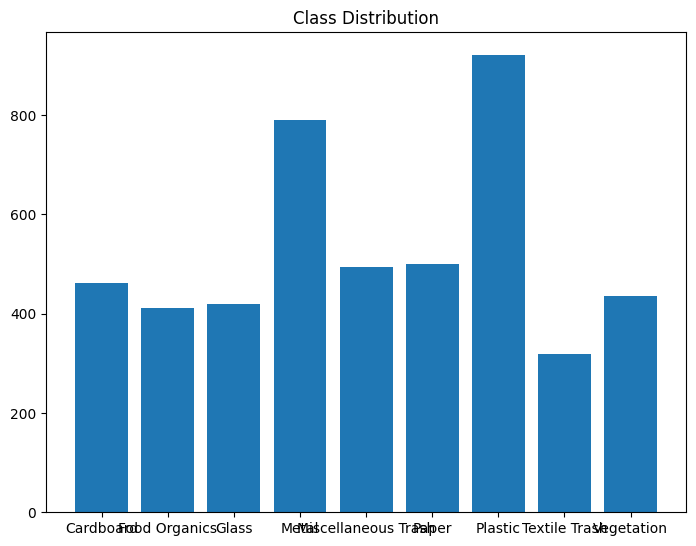

In [ ]:
# display class distribution
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = [461,411,420,790,495,500,921,318,436]
ax.bar(dataset.classes, counts)
plt.title('Class Distribution')
plt.show()

Split the data into train and validation sets. Test set will be provided at the exam.

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Uddrag fra
Deep Learning with Python, Second Edition
François Chollet
Dette materiale kan være beskyttet af ophavsret.